## Machine Learning Online Class - Exercise 3 | Part 1: One-vs-all

####  Instructions
  ------------

  This file contains code that helps you get started on the
  linear exercise. You will need to complete the following functions
  in this exericse:

     lrCostFunction.m (logistic regression cost function)
     oneVsAll.m
     predictOneVsAll.m
     predict.m

  For this exercise, you will not need to change any code in this file,
  or any other files other than those mentioned above.

In [1]:
# Initialization
import numpy as np;
import scipy.io as sio;

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Setup the parameters you will use for this part of the exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
num_labels = 10;          # 10 labels, from 1 to 10
                          # (note that we have mapped "0" to label 10)

#### =========== Part 1: Loading and Visualizing Data =============

In [3]:
#  We start the exercise by first loading and visualizing the dataset.
#  You will be working with a dataset that contains handwritten digits.

# Load Training Data
print('Loading and Visualizing Data ...\n');

mat_contents = sio.loadmat('ex3data1.mat'); # training data stored in arrays X, y
print('   ...Done.')
print('\nContents of mat file...')
print(mat_contents.keys())
X = mat_contents['X'];
y = mat_contents['y'];
m = np.shape(X)[0];
print('\n')
print('Dimensions of X: {0}'.format(X.shape));
print('Dimensions of y: {0}'.format(y.shape));


Loading and Visualizing Data ...

   ...Done.

Contents of mat file...
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


Dimensions of X: (5000, 400)
Dimensions of y: (5000, 1)


In [4]:
# Randomly select 100 data points to display
rand_indices = np.random.permutation(m);
sel = X[rand_indices[0:100], :];
print(sel.shape)
print(sel)

(100, 400)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [5]:
def displayData(X):
    #DISPLAYDATA Display 2D data in a nice grid
    #   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
    #   stored in X in a nice grid. It returns the figure handle h and the 
    #   displayed array if requested.

    # Set example_width automatically
    example_width = np.int_(np.round(np.sqrt(np.shape(X)[1]),0));
    
    # Gray Image
    #colormap(gray);

    # Compute rows, cols
    [m, n] = np.shape(X);
    example_height = np.int_(np.round((n / example_width),0));
    
    # Compute number of items to display
    display_rows = np.int_(np.floor(np.sqrt(m)));
    display_cols = np.int_(np.ceil(m / display_rows));
    
    # Between images padding
    pad = 1;
    # Setup blank display
    
    display_array = - np.ones((np.int_(pad + display_rows * (example_height + pad)), 
                              np.int_(pad + display_cols * (example_width + pad))));

    print('display_rows: {0}, display_cols: {1}, example_height: {2}, example_width: {3}'.format( \
                            display_rows, display_cols, example_height, example_width))
    print('display shape: {0}'.format(display_array.shape));
          
    # Copy each example into a patch on the display array
    curr_ex = 0;
    for j in np.arange(display_rows):
        for i in np.arange(display_cols):
            if curr_ex >= m:
                break;
            # Get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex, :]));
            # Copy the patch
            display_array[np.ix_(np.int_(pad + j * (example_height + pad) + np.arange(example_height)), 
                          np.int_(pad + i * (example_width + pad) + np.arange(example_width)))] = \
                        np.flip(np.reshape(X[curr_ex, :], (example_height, example_width)).T, axis = 0)  / max_val ;
            
            curr_ex = curr_ex + 1;

        if curr_ex >= m:
            break; 

    # Display Image
    plt.imshow(display_array, origin=[-1,1], cmap="Blues");
    # Do not show axis
    plt.axis('off');
    plt.show();
    
    return display_array;


display_rows: 10, display_cols: 10, example_height: 20, example_width: 20
display shape: (211, 211)


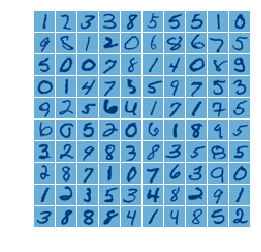

In [6]:
displayData(sel);

In [7]:
def sigmoid(z):
    #SIGMOID Compute sigmoid function
    #   g = SIGMOID(z) computes the sigmoid of z.
    g = 1 / (1 + np.exp(-z));
    return g

In [8]:
def lrCostFunction(theta, X, y, lambda_ex):
    #LRCOSTFUNCTION Compute cost and gradient for logistic regression with 
    #regularization
    #   J = LRCOSTFUNCTION(theta, X, y, lambda) computes the cost of using
    #   theta as the parameter for regularized logistic regression and the
    #   gradient of the cost w.r.t. to the parameters. 

    # Initialize some useful values
    m = np.shape(y)[0]; # number of training examples

    # You need to return the following variables correctly 
    J = 0;
    grad = np.zeros((np.shape(theta)));
    
    # Instructions: Compute the cost of a particular choice of theta.
    #               You should set J to the cost.
    #               Compute the partial derivatives and set grad to the partial
    #               derivatives of the cost w.r.t. each parameter in theta
    #
    # Hint: The computation of the cost function and gradients can be
    #       efficiently vectorized. For example, consider the computation
    #
    #           sigmoid(X * theta)
    #
    #       Each row of the resulting matrix will contain the value of the
    #       prediction for that example. You can make use of this to vectorize
    #       the cost function and gradient computations. 
    #
    # Hint: When computing the gradient of the regularized cost function, 
    #       there're many possible vectorized solutions, but one solution
    #       looks like:
    #           grad = (unregularized gradient for logistic regression)
    #           temp = theta; 
    #           temp(1) = 0;   # because we don't add anything for j = 0  
    #           grad = grad + YOUR_CODE_HERE (using the temp variable)

    y = y.reshape(-1,1);
    hypo = (sigmoid(X.dot(theta))).reshape(-1,1);
    cost = -1 * (1 / m) * (np.log(hypo).T.dot(y) + np.log(1 - hypo).T.dot(1 - y));
    costReg = (lambda_ex / (2*m)) * (np.sum(theta[1:]**2));
    J = cost + costReg;

    errorTerm = (hypo - y);
    gradReg = np.zeros((np.shape(theta)[0],1));
    gradReg[1:] = (lambda_ex / m) * theta[1:].reshape(-1,1);
    grad = (np.sum(errorTerm * X, axis=0)/m).reshape(-1,1) + gradReg;

    return J[0][0], grad.flatten()

#### ============ Part 2a: Vectorize Logistic Regression ============

In [9]:
#  In this part of the exercise, you will reuse your logistic regression
#  code from the last exercise. You task here is to make sure that your
#  regularized logistic regression implementation is vectorized. After
#  that, you will implement one-vs-all classification for the handwritten
#  digit dataset.

# Test case for lrCostFunction
print('Testing lrCostFunction() with regularization');

theta_t = np.array([-2, -1, 1, 2]).reshape(-1,1);
X_t = np.reshape(np.arange(1,15+1),(3,5)).T;
X_t = np.concatenate((np.ones((5,1)), X_t/10), axis=1);
y_t = np.array([1,0,1,0,1]).reshape(-1,1);
lambda_t = 3;
[J, grad] = lrCostFunction(theta_t, X_t, y_t, lambda_t);

print('\nCost: {0:0.6f}'.format(J));
print('Expected cost: 2.534819');
print('\nGradients:');
for i in np.arange(np.shape(grad)[0]):
    print(' {0:0.6f} '.format(grad[i]));
print('\nExpected gradients:');
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n');

Testing lrCostFunction() with regularization

Cost: 2.534819
Expected cost: 2.534819

Gradients:
 0.146561 
 -0.548558 
 0.724722 
 1.398003 

Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003



#### ============ Part 2b: One-vs-All Training ============

In [10]:
from scipy.optimize import minimize

def oneVsAll(X, y, num_labels, lambda_ex):
    #ONEVSALL trains multiple logistic regression classifiers and returns all
    #the classifiers in a matrix all_theta, where the i-th row of all_theta 
    #corresponds to the classifier for label i
    #   [all_theta] = ONEVSALL(X, y, num_labels, lambda) trains num_labels
    #   logistic regression classifiers and returns each of these classifiers
    #   in a matrix all_theta, where the i-th row of all_theta corresponds 
    #   to the classifier for label i

    # Some useful variables
    [m, n] = np.shape(X);

    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1));

    # Add ones to the X data matrix
    Xml = np.concatenate((np.ones((m,1)), X), axis=1);

    # ====================== YOUR CODE HERE ======================
    # Instructions: You should complete the following code to train num_labels
    #               logistic regression classifiers with regularization
    #               parameter lambda. 
    #
    # Hint: theta(:) will return a column vector.
    #
    # Hint: You can use y == c to obtain a vector of 1's and 0's that tell you
    #       whether the ground truth is true/false for this class.
    #
    # Note: For this assignment, we recommend using fmincg to optimize the cost
    #       function. It is okay to use a for-loop (for c = 1:num_labels) to
    #       loop over the different classes.
    #
    #       fmincg works similarly to fminunc, but is more efficient when we
    #       are dealing with large number of parameters.
    #
    # Example Code for fmincg:
    #
    #     # Set Initial theta
    #     initial_theta = zeros(n + 1, 1);
    #     
    #     # Set options for fminunc
    #     options = optimset('GradObj', 'on', 'MaxIter', 50);
    # 
    #     # Run fmincg to obtain the optimal theta
    #     # This function will return theta and the cost 
    #     [theta] = ...
    #         fmincg (@(t)(lrCostFunction(t, X, (y == c), lambda)), ...
    #                 initial_theta, options);
    #

    for i in np.arange(num_labels):
        initial_theta = np.zeros((np.shape(Xml)[1], 1));
        c = (y == (i+1)).reshape(-1,1) # use i+1 as python numpy array have a zero index.
        Result = minimize(fun = lrCostFunction, 
                                 x0 = initial_theta, 
                                 args = (Xml, c, lambda_ex),
                                 method = 'L-BFGS-B',
                                 jac = True, # set to true as costFunction returns both the cost and gradient
                                 options={'disp': True, 
                                          'gtol': 1e-05, 
                                          'maxiter': 50});

        optimal_theta = Result.x;
        cost = Result.fun;
        print('i: {0}, \tcost: {1:0.6f}'.format(i+1, cost));
        all_theta[i, :] = optimal_theta;

    return all_theta


In [11]:
print('\nTraining One-vs-All Logistic Regression...\n')
lambda_ex = 0.1;
all_theta = oneVsAll(X, y, num_labels, lambda_ex);


Training One-vs-All Logistic Regression...

i: 1, 	cost: 0.013151
i: 2, 	cost: 0.052497
i: 3, 	cost: 0.058868
i: 4, 	cost: 0.033605
i: 5, 	cost: 0.055913
i: 6, 	cost: 0.018481
i: 7, 	cost: 0.031131
i: 8, 	cost: 0.080051
i: 9, 	cost: 0.072360
i: 10, 	cost: 0.008603


#### ================ Part 3: Predict for One-Vs-All ================

In [12]:
def predictOneVsAll(all_theta, X):
    #PREDICT Predict the label for a trained one-vs-all classifier. The labels 
    #are in the range 1..K, where K = size(all_theta, 1). 
    #  p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
    #  for each example in the matrix X. Note that X contains the examples in
    #  rows. all_theta is a matrix where the i-th row is a trained logistic
    #  regression theta vector for the i-th class. You should set p to a vector
    #  of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
    #  for 4 examples) 

    m = np.shape(X)[0];
    num_labels = np.shape(all_theta)[0];

    # You need to return the following variables correctly 
    p = np.zeros((np.shape(X)[0], 1));

    # Add ones to the X data matrix
    Xml = np.concatenate((np.ones((m,1)), X), axis=1);

    # ====================== YOUR CODE HERE ======================
    # Instructions: Complete the following code to make predictions using
    #               your learned logistic regression parameters (one-vs-all).
    #               You should set p to a vector of predictions (from 1 to
    #               num_labels).
    #
    # Hint: This code can be done all vectorized using the max function.
    #       In particular, the max function can also return the index of the 
    #       max element, for more information see 'help max'. If your examples 
    #       are in rows, then, you can use max(A, [], 2) to obtain the max 
    #       for each row.
    #       

    c = Xml.dot(all_theta.T);
    p = (np.argmax(c, axis=1)+1).reshape(-1,1);
    return p.reshape(-1,1);

In [13]:
pred = predictOneVsAll(all_theta, X);
print('\nTraining Set Accuracy: {0:0.2f}%\n'.format(np.mean(((pred) == y)) * 100));


Training Set Accuracy: 96.20%



## Machine Learning Online Class - Exercise 3 | Part 2: Neural Networks

####  Instructions
-------------
 
  This file contains code that helps you get started on the
  linear exercise. You will need to complete the following functions 
  in this exericse:

     lrCostFunction.m (logistic regression cost function)
     oneVsAll.m
     predictOneVsAll.m
     predict.m

  For this exercise, you will not need to change any code in this file,
  or any other files other than those mentioned above.

In [14]:
## Initialization

In [15]:
## Setup the parameters you will use for this exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

#### =========== Part 1: Loading and Visualizing Data =============

In [16]:
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.
#

# Load Training Data
print('Loading and Visualizing Data ...\n');

mat_contents = sio.loadmat('ex3data1.mat'); # training data stored in arrays X, y
print(mat_contents.keys())
X = mat_contents['X'];
y = mat_contents['y'];
m = np.shape(X)[0];
print('   ...Done.')

Loading and Visualizing Data ...

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
   ...Done.


display_rows: 10, display_cols: 10, example_height: 20, example_width: 20
display shape: (211, 211)


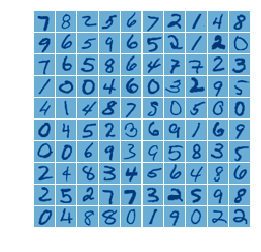

In [17]:
# Randomly select 100 data points to display
rand_indices = np.random.permutation(m);
sel = X[rand_indices[0:100], :];

displayData(sel);

#### ================ Part 2: Loading Pameters ================

In [18]:
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.

print('\nLoading Saved Neural Network Parameters ...\n')

# Load the weights into variables Theta1 and Theta2
mat_contents = sio.loadmat('ex3weights.mat');
print('   ...Done.')

print(mat_contents.keys())
Theta1 = mat_contents['Theta1'];
Theta2 = mat_contents['Theta2'];


Loading Saved Neural Network Parameters ...

   ...Done.
dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])


#### ================= Part 3: Implement Predict =================

In [19]:
def predict(Theta1, Theta2, X):
    #PREDICT Predict the label of an input given a trained neural network
    #   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
    #   trained weights of a neural network (Theta1, Theta2)

    # Useful values
    [m, n] = np.shape(X);
    num_labels = np.shape(Theta2)[0];

    # You need to return the following variables correctly 
    p = np.zeros((np.shape(X)[0], 1));
    
    # ====================== YOUR CODE HERE ======================
    # Instructions: Complete the following code to make predictions using
    #               your learned neural network. You should set p to a 
    #               vector containing labels between 1 to num_labels.
    #
    # Hint: The max function might come in useful. In particular, the max
    #       function can also return the index of the max element, for more
    #       information see 'help max'. If your examples are in rows, then, you
    #       can use max(A, [], 2) to obtain the max for each row.
    #

    Xml = np.concatenate((np.ones((m,1)), X), axis=1);
    Z = Xml.dot(Theta1.T);
    A1 = sigmoid(Z);
    A1 = np.concatenate((np.ones((m,1)), A1), axis=1);
    Z2 = A1.dot(Theta2.T);
    A2 = sigmoid(Z2);
    p = (np.argmax(A2, axis=1)+1).reshape(-1,1);
    return p;

In [20]:
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X);
print('\nTraining Set Accuracy: {0}\n'.format(np.mean((pred == y)) * 100));


Training Set Accuracy: 97.52



In [21]:
#### Multiclass Logistic Regression with scikit-learn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=10, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
clf.fit(X[:,1:],y.ravel())

pred2 = clf.predict(X[:,1:])
print('Training set accuracy: {} %'.format(np.mean(pred2 == y.ravel())*100))

Training set accuracy: 96.5 %


Displaying Example Image: 1043

display_rows: 1, display_cols: 1, example_height: 20, example_width: 20
display shape: (22, 22)


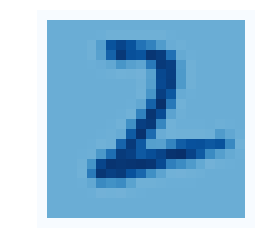

Neural Network Prediction: 2 (digit 2)



In [22]:
#  To give you an idea of the network's output, you can also run
#  through the examples one at the a time to see what it is predicting.

#  Get random image row to display
i = np.random.randint(0, np.shape(X)[0]-1)

# Display
print('Displaying Example Image: {0}\n'.format(i));
displayData(X[i, :].reshape(1,-1));

pred = predict(Theta1, Theta2, X[i, :].reshape(1,-1));
print('Neural Network Prediction: {0} (digit {1})\n'.format(pred[0][0], pred[0][0]%10));
